In [1]:
#code by Tobias Gensch with contributions from Ellyn Peters, Jen Crawford, and Cian Kingston
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed
import warnings
warnings.filterwarnings("ignore")
import loo_q2 as loo
randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="selectivity",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)      
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    plt.figure(figsize=(6,6))
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=150)
    plt.scatter(y_train,y_pred_train,label="training",color="#1d0ba3",marker=".",s=150,alpha=0.75)
    plt.scatter(y_test,y_pred_test,label="test",color="#ab1513",marker=".",s=150,alpha=0.75)
    plt.plot(y_train,yy_fit_line,color="black",alpha=0.4)
    if leg:
        plt.legend(loc='lower right',fontsize=10)
    plt.xlabel("measured "+label,fontsize=14)
    plt.ylabel("predicted "+label,fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)

def plot_fit_screen(y_train,y_pred_train,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(y_train)
    y_pred_min = np.min(y_pred_train)
    y_orig_max = np.max(y_train)
    y_pred_max = np.max(y_pred_train)
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    plt.figure(figsize=(5,5))
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=100)
    plt.scatter(y_train,y_pred_train,label="training",color="b",marker=".",s=100,alpha=0.75)
    plt.plot(y_train,yy_fit_line,color="black",alpha=0.4)
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel(label+" measured",fontsize=10)
    plt.ylabel(label+" predicted",fontsize=10)
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)      
        
def r2_val_2(y_test,y_pred_test):
    y_resid = y_test - y_pred_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_test)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=5, n=100):
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

**Read data**

In [2]:
comp_file = "gen_parameters_xtb_DFT"
comp_sheet = "Sheet1"
num_par = 385
par_start_col = 2
comp_num_samples = 21
y_label_col_comp = 0 

exp_file = "gen_data_xtb_DFT"
exp_sheet = "Sheet1"
exp_num_samples = 21
response_col = 2
y_label_col_exp = 1

**Sort data**

In [3]:
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp = compinp.drop(['smiles'],axis=1)
par_start_col = 1
compinp.index = compinp.index.map(str)

expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=2,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)),engine='openpyxl')

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]
X_labelname = [" ".join(i) for i in zip(X_labels,X_names)]
X_labelname_dict = dict(zip(X_labels,X_names))
resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)
mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X

print("Number of entries in experimental file before removing empty cells: {}".format(len(y)))
print("Removing {} entries with empty cells".format(len(y)-sum(mask)))

y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]
X = np.asarray(compinp.loc[y_labels],dtype=np.float)

print("Shape of descriptors file for all ligands: {}".format(X_all.shape))
print("Last three ids in the descriptor file: {}".format(y_labels_comp[-3:]))
print("Shape of descriptors file for ligands with experimental results: {}".format(X.shape))
print("Shape of results file results (only ligands with experimental results): {}".format(y.shape)) 
print("Shape of results file labels (only ligands with experimental results): {}".format(y_labels.shape))
print("First descriptor cell (for ligands with experimental results): {}".format(X[0,0]))
print('Ligands with results:',y_labels)
print('Experimental results:',y)

Number of entries in experimental file before removing empty cells: 21
Removing 0 entries with empty cells
Shape of descriptors file for all ligands: (21, 385)
Last three ids in the descriptor file: ['19' '20' '21']
Shape of descriptors file for ligands with experimental results: (21, 385)
Shape of results file results (only ligands with experimental results): (21,)
Shape of results file labels (only ligands with experimental results): (21,)
First descriptor cell (for ligands with experimental results): 4.40709650963888
Ligands with results: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21']
Experimental results: [ 0.10720997  0.29666519  0.59439255  0.01283722  0.18184359  0.24551267
 -0.00436481  0.05690485 -0.01322827  0.55509445 -0.18045606  0.20411998
  0.26481782  0.49136169  0.00860017  0.74766486  0.71883301  0.2093233
  0.36444607  0.07448883  0.07448883]


**Univariate correlations**

x31 qvbur_min_boltz


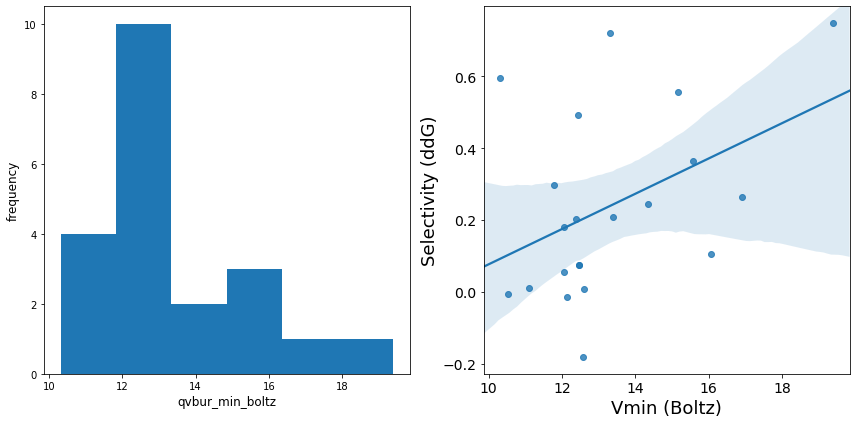

R^2 = 0.18; p-value = 0.05

-------------------------------------------------------------------------------



In [4]:
### All features:
#features = range(np.shape(X)[1])

### Features by X-numbers (1-indexed):
features_x = ["x31"]
features = [X_labels.index(i) for i in features_x]

r2_cutoff = 0.0
r2_values = []

for f_ind in features:
    feature = X_labels[f_ind]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    r2 = r_value**2
    r2_values.append(r2)
    if r2 > r2_cutoff:
        print(feature, X_names[f_ind])
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.hist(X[:,f_ind], bins="auto")
        plt.ylabel("frequency",fontsize=12)
        plt.xlabel(X_names[f_ind],fontsize=12)
        plt.tight_layout()
        plt.subplot(1,2,2)
        sns.regplot(X[:,f_ind],y,ci=95,truncate=False)
        x_max=np.max(X[:,f_ind])
        x_min=np.min(X[:,f_ind])
        y_max=np.max(y)
        y_min=np.min(y)
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)      
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
        plt.xlabel('Vmin (Boltz)',fontsize=18)
        plt.ylabel("Selectivity (ddG)",fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.show()
        if p_value > 0.01:
            print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
        else:
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
        print("\n-------------------------------------------------------------------------------\n")

**Training/test set split and feature scaling**

Methods to split the data:
- 'random'
- 'y_equidist': picks points that evenly span the output variable y. Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section.
- 'ks': Kennard Stone algorithm picks points based on an even distriution in feature space
- 'define': give a list of sample indices for either VS or TS in the corresponding code section 
- 'none': all samples in TS

TS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
VS: [20]
y_mean TS: 0.247
y_mean VS: 0.074
Shape X_train: (20, 385)
Shape X_test:  (1, 385)


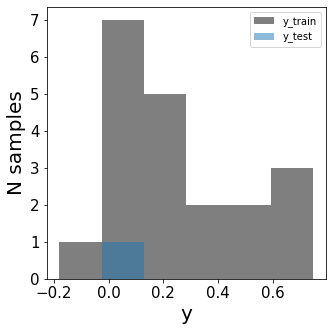

In [5]:
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

split = "define"
test_ratio = 0.05

###################################################################################################

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test] 
elif split == "define":
    TS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    #TS = [i-1 for i in VS]
    VS = [20]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS] 
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   
elif split == "y_equidist":
    no_extrapolation = True
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])
    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]  
else: 
    raise ValueError("split option not recognized")
     
print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

**Feature scaling**

In [6]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

**Forward stepwise selection**

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 37.0092
Done. Time taken (minutes): 0.62


Best model:
1 + x225 + x316
1 + nbo_bds_e_min_boltz + vbur_ovbur_min_boltz

Parameters and coefficients:
    0.2468 + 
   -0.2057 * x225 nbo_bds_e_min_boltz
    0.1923 * x316 vbur_ovbur_min_boltz

Training R2  = 0.761
Training Q2  = 0.626
Training K-fold R2 = 0.624 (+/- 0.001)
Training MAE = 0.098

Test R2   = -inf
Test MAE     = 0.231


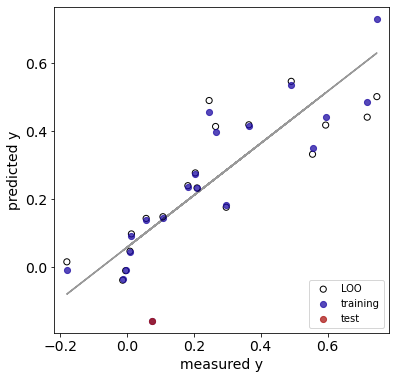

In [9]:
#skipfeatures = []
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
#df.drop(skipfeatures,axis=1,inplace=True)

##############################################################################################################

# define variables for f.s.s.

n_steps = 2             # no. of terms (do one more than the number you want; consequence of the algorithm)
n_candidates = 15       # 10 or 15 usually
collin_criteria = 0.5   # the maximum R2 between terms

##############################################################################################################

import ForwardStepCandidates_updated as fsc
results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
print("\n\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=10,n=100)
print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))
print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")
print(f"\nTest R2   = {r2_val_2(y_test,y_pred_test):.3f}")
print(f"Test MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)


**Calculate test R2 for models in results and filter the results**

In [52]:
test_R2s = []
for i in range(0,len(results)):
    model_sel = results.loc[i,"Model"]
    selected_feats = [X_labels.index(j) for j in models[model_sel].terms]
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)
    test_R2 = r2_val_2(y_test,y_pred_test)
    test_R2s.append(test_R2)
results['test_R2'] = test_R2s
results['diff_R2'] = results['R^2']-results['test_R2']
results['diff_Q2'] = results['R^2']-results['Q^2']
results2 = results.sort_values(ascending=False,by=['test_R2'])
validatedmodels = results[results.n_terms<=4][results.test_R2>0.75][results.diff_Q2<0.1][results.diff_R2<0.1][results.diff_R2>0].sort_values(by=['test_R2'],ascending=False)
print('Number of models =',len(validatedmodels))
validatedmodels.head(10)

Number of models = 0


,Model,n_terms,R^2,Q^2,test_R2,diff_R2,diff_Q2


**Visualize a specific model**


Parameters:
    0.2199 + 
   -0.1124 * x31 nbo_bds_e_avg_boltz
    0.0150 * x48 volume_boltz

Training R2  = 0.199
Training Q2  = -0.746
Training MAE = 0.162
Training K-fold R2 = -0.895 (+/- 0.298)

Test R2      = -inf
Test MAE     = 0.028


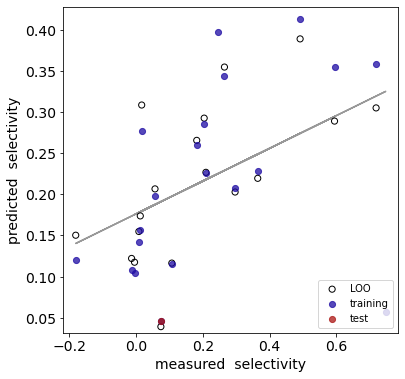

In [61]:
#model_sel = results.loc[325,"Model"]
model_sel = ('x31','x48')

selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")
print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val_2(y_test,y_pred_test):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label=" selectivity",loo_pred=loo_train)

**Virtual screening setup**

In [45]:
ci = pd.read_excel('gen_descriptors.xlsx','Sheet1',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)
inp2 = pd.read_excel("gen_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)
X_all = np.array(compinp)
X_gen_considered = np.array(compinp.loc[inp2["gen_considered"]==1])
scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc    = scaler.transform(X_all)
X_gen_considered_sc = scaler.transform(X_gen_considered)
X_all_ids = np.array(compinp.index)
X_gen_considered_ids = np.array(compinp.loc[inp2["gen_considered"]==1].index)
X_all_names = np.array(inp2["ligand"].loc[X_all_ids])
X_gen_considered_names = np.array(inp2['ligand'].loc[X_gen_considered_ids])
print('Number of samples in original training set = ',len(y_train))
y_train = np.concatenate((y_train,y_test), axis=0)
X_train_sc = np.concatenate((X_train_sc,X_test_sc), axis=0)
print('Number of samples in updated training set = ',len(y_train))

Number of samples in original training set =  14
Number of samples in updated training set =  20


**Choose the subset to virtually screen**

In [46]:
X_screen_sc = X_gen_considered_sc
X_ids = X_gen_considered_ids.astype(str)
X_names = X_gen_considered_names

**Remove ligands based on feature values**

Values chosen based on threshold analysis of HTE reactivity results; vmin_vmin_boltz (x1) over -0.07 and vbur_vbur_min (x87) under 58.22. Ligands must pass both thresholds to be considered for screening.

In [47]:
X_filter = X_gen_considered    # choose the subset to filter
X_filter_sc = X_gen_considered_sc
X_filter_ids = X_gen_considered_ids.astype(str)
X_filter_names = X_gen_considered_names

X_filtered_screen_sc = []
X_filtered_ids = []
X_filtered_names = []
x1_count = 0
x87_count = 0
for i in range(0,len(X_filter_sc)):
    count = 0
    if X_filter[i][0] > -0.07:
        count += 1
    else:
        x1_count += 1
    if X_filter[i][86] < 58.22:
        count += 1
    else:
        x87_count += 1
    if count == 2:
        X_filtered_screen_sc.append(X_filter_sc[i])
        X_filtered_ids.append(X_filter_ids[i])
        X_filtered_names.append(X_filter_names[i])
    else:
        pass
X_filtered_screen_sc = np.asarray(X_filtered_screen_sc)
X_filtered_ids = np.asarray(X_filtered_ids) 
X_filtered_names = np.asarray(X_filtered_names) 
X_screen_sc = X_filtered_screen_sc
X_ids = X_filtered_ids
X_names = X_filtered_names
print(len(X_filter_sc),'ligands originally')
print(len(X_screen_sc),'after filtering, these should match:',len(X_ids),'and',len(X_names))
print(x1_count,'ligands failed x1 threshold')
print(x87_count,'ligands failed x87 threshold')

403 ligands originally
302 after filtering, these should match: 302 and 302
9 ligands failed x1 threshold
100 ligands failed x87 threshold


**Virtually screen using multiple models: Set up the correlation map**

In [48]:
par_start_col = 2
compinp2 = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp2 = compinp2.drop(['smiles'],axis=1)
compinp2.index = compinp2.index.map(str)
compinp2.drop(index=compinp2.index[0],inplace=True)
compinp2.reset_index(level=0, inplace=True)
compinp2 = compinp2.drop(columns='x')
compinp2 = compinp2.astype(float)
corr_map = compinp2.corr()

**Define the set of models for virtual screening**

In [50]:
data_top = validatedmodels.head(5)
best_models = list(data_top.index)
best_models_formulae = list(data_top['Model'])
best_models_ids_formulae = []
for i in range(0,len(best_models)):
    x = best_models[i]
    y = best_models_formulae[i]
    z = [x,y]
    best_models_ids_formulae.append(z)
print('len best_models =',len(best_models))
print('best_models =',best_models)
print('')
keep_models = []
keep_models.append(best_models[0])
print('keep_models =',keep_models)
keep_models_formulae = []
keep_models_formulae.append(best_models_formulae[0])

len best_models = 0
best_models = []



IndexError: list index out of range

**Remove collinear models**

In [15]:
collin_criteria = 0.5

collin_criteria = np.sqrt(collin_criteria)
for i in best_models_formulae:
    add_bm = []
    for j in keep_models_formulae:                               
        bm_colin_feat=[]
        bm = list(i)                                 
        km = list(j)
        new_bm = [a for a in bm if a not in km]
        new_km = [b for b in km if b not in bm]
        for k in new_bm:
            for l in new_km:
                colinearity = abs(corr_map.loc[k,l])
                if colinearity>collin_criteria:
                    x = [k,l]
                    bm_colin_feat.append(x)
                else:
                    pass
        if not new_bm:
            pass
        else:        
            for m in range(0,len(bm_colin_feat)):
                try:
                    new_bm.remove(bm_colin_feat[m][0])
                except ValueError:
                    pass
            if not new_bm:
                add_bm.append('dont add')
            else:
                add_bm.append('do add')
    if not add_bm:
        pass
    elif 'dont add' in add_bm:
        pass
    else:
        keep_models_formulae.append(i)
            
print('len bmf = ',len(best_models_formulae))
print('len kmf = ',len(keep_models_formulae))
new_best_models = []
for i in range(0,len(best_models_ids_formulae)):
    for j in range(0,len(keep_models_formulae)):
        if best_models_ids_formulae[i][1] == keep_models_formulae[j]:
            new_best_models.append(best_models_ids_formulae[i][0])     
print('len new_best_models = ',len(new_best_models))
print('new_best_models = ',new_best_models)

len bmf =  73
len kmf =  41
len new_best_models =  41
new_best_models =  [325, 72, 258, 508, 435, 363, 1100, 1066, 591, 467, 370, 1191, 1422, 553, 491, 1024, 1350, 447, 1215, 384, 779, 1300, 1582, 847, 1162, 562, 381, 1847, 649, 1284, 1491, 271, 1012, 2096, 1290, 566, 1530, 1708, 1974, 1751, 1036]


**Virtually screen using the defined set of models**

minimum actual response value = -1.0340110798873816
maximum actual response value = 0.8630693575460081

Training R2 for best model = 0.8734154461867759
Training R2 for worst model = 0.8469204741941768


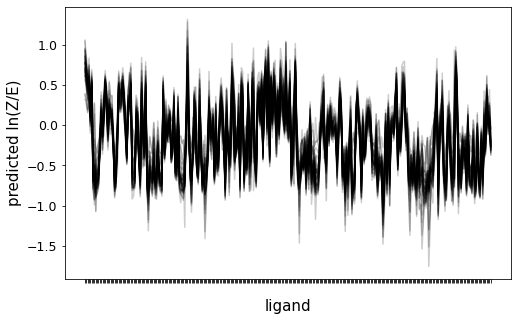

In [16]:
X_combined = []
for i in range(0,len(X_ids)):
    j = str(X_names[i]) + " (ID " + X_ids[i] + ")"
    X_combined.append(j)
headings = ['Ligand']
for i in range(0,len(new_best_models)):
    j = 'model ' + str(new_best_models[i])
    headings.append(j)    
print('minimum actual response value =',min(y_train))
print('maximum actual response value =',max(y_train))
plt.figure(figsize=(8,5))
plt.xticks(fontsize=12.5) 
plt.yticks(fontsize=12.5)
plt.xlabel("ligand",fontsize=15,labelpad=20)
plt.ylabel("predicted ln(Z/E)",fontsize=15,labelpad=5)
plt.tick_params(axis='x', labelbottom=False)
training_R2s = []
pred_results = {'ligands': X_combined}
for i in new_best_models:
    model_sel = results.loc[i,"Model"]
    selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
    X_train_sel = X_train_sc[:,selected_feats]
    X_screen_sel = X_screen_sc[:,selected_feats]
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_screen =  lr.predict(X_screen_sel)
    training_R2s.append(lr.score(X_train_sel, y_train))
    plt.plot(X_combined, y_pred_screen, color="black", label = 'model '+str(i), alpha = 0.2)
    pred_results[str(i)] = y_pred_screen
print('')    
print('Training R2 for best model =',training_R2s[0])
print('Training R2 for worst model =',training_R2s[-1])
plt.show()

**df of all the predicted results**

In [17]:
df = pd.DataFrame.from_dict(pred_results)
df1 = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df1.set_properties(**{'text-align': 'center'}).hide_index()
df1

**Analyzing the predicted selectivities**

In [18]:
df = pd.DataFrame.from_dict(pred_results)
df = df.set_index('ligands')
df['average'] = df.mean(axis=1)
df['std_dev'] = df.std(axis=1)
df = df.filter(['average','std_dev'])
df_2 = df[df.std_dev<0.3]
df_2

,average,std_dev
ligands,,
Xphos (ID 1),0.747077,0.159000
SPhos (ID 3),0.610026,0.129383
RuPhos (ID 4),0.449415,0.120696
CyJohnPhos (ID 5),0.513811,0.142524
PhSPhos (ID 7),0.114887,0.095939
...,...,...
"PPh(2,4Xyl)2 (ID 1433)",-0.232610,0.096448
NMe2Ph3PCy2_Indole (ID 1436),0.345970,0.118492
PtBu H4phosphepine (ID 1438),0.061828,0.121652


**Ligands with predicted selectivities below the experimental minimum**

In [19]:
print('Minimum experimental result = ',min(y_train))
df_low = df_2.copy()
df_low = df_low[df_low.average < min(y_train)]
df_low

Minimum experimental result =  -1.0340110798873816


,average,std_dev
ligands,,


**Ligands with predicted selectivities above the experimental maximum**

In [20]:
print('Maximum experimental result = ',max(y_train))
df_high = df_2.copy()
df_high = df_high[df_high.average > max(y_train)]
df_high

Maximum experimental result =  0.8630693575460081


,average,std_dev
ligands,,
